# Example: Apply the f-k convolutional neural network model

This notebook demonstrates how to apply a previously trained f-k convolutional neural network model.  The demo uses the trained model shown in the manuscript. This model is defined in `src/fk_convolutional_neural_network.py` and the input data, trained model weights, and fitted normalizations should be downloaded from Dryad (https://doi.org/10.5061/dryad.brv15dvnz) and saved to the `input_data` folder.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from matplotlib.gridspec import GridSpec

from src import das_xarray_helpers
from src import plots
from src import fk_convolutional_neural_network
from src import training_and_inference
from src import transforms
from src import waves

Input data, model weights, and fitted normalizations can be downloaded from Dryad (https://doi.org/10.5061/dryad.brv15dvnz) and should be saved to the `input_data` folder. See `input_data/README.md` for additional details on the data files and structure.

In [2]:
HALF_HOURLY_DAS_MOORING_DATA_PATH = 'input_data/oliktok_das_mooring_half-hourly_dataset.nc'
HYPERPARAMETERS_PATH = 'input_data/model_states/fk_convolutional_neural_network_hyperparameters.pth'
MODEL_STATE_DICT_PATH = 'input_data/model_states/fk_convolutional_neural_network_model.pth'
SPECTRAL_FEATURE_NORM_STATE_DICT_PATH = 'input_data/model_states/fk_convolutional_neural_network_spectral_feature_norm.pth'
TARGET_NORM_STATE_DICT_PATH = 'input_data/model_states/fk_convolutional_neural_network_target_norm.pth'

The f-k convolutional neural network uses half-hourly DAS data.

In [3]:
das_30min_ds = xr.open_dataset(HALF_HOURLY_DAS_MOORING_DATA_PATH)

Stack site and time dimensions into a single dimension, so that feature arrays can be fed sequentially to the model.

In [4]:
das_30min_stack_ds = das_xarray_helpers.stack_site_and_time(das_30min_ds)
das_30min_stack_ds

<xarray.Dataset> Size: 11MB
Dimensions:                                    (wavenumber: 32, frequency: 32,
                                                time_site: 1284)
Coordinates:
  * wavenumber                                 (wavenumber) float64 256B -0.0...
  * frequency                                  (frequency) float64 256B 0.01 ...
  * time_site                                  (time_site) object 10kB MultiIndex
  * time                                       (time_site) datetime64[ns] 10kB ...
  * site                                       (time_site) int64 10kB 1 2 ... 3
Data variables:
    strain_fk_spectral_density                 (time_site, wavenumber, frequency) float64 11MB ...
    depth                                      (time_site) float64 10kB -5.54...
    target_seafloor_pressure_spectral_density  (time_site, frequency) float64 329kB ...
    target_seafloor_pressure_variance          (time_site) float64 10kB 0.027...
    target_significant_wave_height             (time_site) float64 10kB 0.901...
    target_energy_period                       (time_site) float64 10kB 6.979...
    is_train                                   (time_site) bool 1kB True ... ...
    is_test                                    (time_site) bool 1kB False ......
Attributes:
    history:        2025-10-17T10:41. Created.
    title:          DAS and seafloor mooring data to accompany the article "N...
    summary:        Half-hourly DAS features and target mooring variables for...
    id:             https://doi.org/10.5061/dryad.brv15dvnz
    license:        CC0
    date_created:   2025-10-17T10:41
    creator_name:   Jacob Davis (UW-APL, WHOI)
    creator_email:  jacob.davis@whoi.edu
    institution:    University of Washington Applied Physics Laboratory (UW-A...
    references:     
    comment:        See accompanying publication in "references" attribute
    _FillValue:     nan

Apply data transformations and convert DataArrays to a feature tensor (Note: default transforms for this model are set to None).

In [ ]:
# This model does not use any feature or target transforms, but these
# could be added in the future.
spectral_feature_transform = None
target_transform = None


# Convert training and test datasets to tensors. Note that data are
# transformed inside this function.
feature_tensor = fk_convolutional_neural_network.feature_tensor_from_dataset(
    das_ds=das_30min_stack_ds,
    spectral_feature_transform=spectral_feature_transform,
)

# Shape is [time_site, 1, k, f])
feature_tensor

tensor([[[[ 189081.6719,  181636.7500,  201414.7344,  ...,  164173.5781,
            144160.0625,  126643.0938],
          [ 155043.9844,  182373.6250,  162363.4531,  ...,  150817.3281,
            150706.9844,  136486.7656],
          [ 149115.2188,  141239.0312,  149984.6094,  ...,  181766.5781,
            177059.7969,  137946.9062],
          ...,
          [ 158164.3438,  147822.2344,  152667.5000,  ...,  109034.8984,
            105335.3672,   86320.2734],
          [ 160110.1719,  158214.1094,  182111.1406,  ...,  120141.7266,
            124990.9609,  102638.6016],
          [ 125893.5469,  193433.1250,  156386.5781,  ...,  110601.4844,
            104645.7188,  118483.8984]]],


        [[[ 225058.1719,  219976.6406,  201143.6719,  ..., 1620566.3750,
            744256.5000,  707992.8125],
          [ 317605.1875,  262260.3438,  227701.4531,  ..., 2366741.2500,
           1272377.8750,  833108.6875],
          [ 264068.5938,  174221.8750,  219849.0156,  ..., 3287795.7500,
    

Load the trained model's hyperparameters and state dictionary and reconstruct the neural network.

In [6]:
hyperparameters = torch.load(HYPERPARAMETERS_PATH)

model = fk_convolutional_neural_network.FkConvolutionalNeuralNetwork(
   dim_in=hyperparameters['dim_in'],
   dim_out=hyperparameters['dim_out'],
   latent_dim=hyperparameters['latent_dim'],
   nb_filters_enc=hyperparameters['nb_filters_enc'],
   nb_filters_dec=hyperparameters['nb_filters_dec'],
)
model.load_state_dict(
   state_dict=torch.load(MODEL_STATE_DICT_PATH),
)
model

FkConvolutionalNeuralNetwork(
  (enc_conv_layers): EncConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.1)
      (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.1)
      (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (enc_linear_layer): Linear(in_features=4096, out_features=4, bias=True)
  (dec_linear_layer): Linear(in_features=4, out_features=512, bias=True)
  (dec_dilated_conv_layers): DecDilatedConvBlock(
    (block): Sequential(
      (0): Conv1d(16, 16, kernel_size=(3,), stride=(1,), pad

Define feature and target min-max normalizations and load their state dicts.


In [10]:
# Initialize normalization transforms and load their state dicts.
spectral_feature_norm = transforms.MinMaxNormalization()
target_norm = transforms.MinMaxNormalization()

spectral_feature_norm.load_state_dict(
    torch.load(SPECTRAL_FEATURE_NORM_STATE_DICT_PATH)
)
target_norm.load_state_dict(
    torch.load(TARGET_NORM_STATE_DICT_PATH)
)

<All keys matched successfully>

Apply normalizations to the feature tensor. NOTE: it is important that the feature tensor is not normalized more than once.

In [11]:
# Clone the feature tensor so it is not normalized in place.
feature_tensor_norm = feature_tensor.clone()
feature_tensor_norm = spectral_feature_norm.transform(feature_tensor)

feature_tensor_norm

tensor([[[[6.3396e-05, 5.9346e-05, 7.0104e-05,  ..., 4.9847e-05,
           3.8962e-05, 2.9434e-05],
          [4.4882e-05, 5.9747e-05, 4.8863e-05,  ..., 4.2583e-05,
           4.2523e-05, 3.4788e-05],
          [4.1657e-05, 3.7373e-05, 4.2130e-05,  ..., 5.9417e-05,
           5.6857e-05, 3.5582e-05],
          ...,
          [4.6579e-05, 4.0954e-05, 4.3589e-05,  ..., 1.9856e-05,
           1.7844e-05, 7.5012e-06],
          [4.7637e-05, 4.6606e-05, 5.9604e-05,  ..., 2.5897e-05,
           2.8535e-05, 1.6377e-05],
          [2.9026e-05, 6.5762e-05, 4.5612e-05,  ..., 2.0708e-05,
           1.7469e-05, 2.4996e-05]]],


        [[[8.2964e-05, 8.0200e-05, 6.9956e-05,  ..., 8.4202e-04,
           3.6537e-04, 3.4564e-04],
          [1.3330e-04, 1.0320e-04, 8.4402e-05,  ..., 1.2479e-03,
           6.5263e-04, 4.1370e-04],
          [1.0418e-04, 5.5313e-05, 8.0131e-05,  ..., 1.7489e-03,
           9.0356e-04, 6.2040e-04],
          ...,
          [1.0377e-04, 8.9524e-05, 9.5273e-05,  ..., 1.12

Apply the model to the transformed and normalized feature tensor.  Order is important when inverse transforming the model output: first inverse the target normalization, then inverse the target transformation, if applicable (predictions and targets share the same transformations).

In [14]:
# Apply the model.
prediction_tensor = training_and_inference.apply_regression_model(model, feature_tensor_norm)

# Reverse the normalization to get back to original pressure units.
prediction_tensor_no_norm = target_norm.inverse_transform(prediction_tensor)

# And reverse transformations, if applicable.
if target_transform is not None:
    prediction_tensor_no_transform = target_transform.inverse_transform(prediction_tensor_no_norm)
else:
    prediction_tensor_no_transform = prediction_tensor_no_norm

prediction_tensor_no_transform

tensor([[5.3256e-03, 7.2670e-03, 5.3065e-03,  ..., 2.9775e-05, 2.0923e-05,
         2.2767e-05],
        [2.2317e-03, 1.9773e-03, 1.5861e-03,  ..., 1.5526e-05, 9.7281e-06,
         1.4022e-05],
        [1.3897e-03, 1.0012e-03, 8.2551e-04,  ..., 1.0183e-05, 6.7688e-06,
         9.8831e-06],
        ...,
        [2.0008e-03, 2.2594e-03, 1.4675e-03,  ..., 1.2416e-05, 9.7448e-06,
         9.9619e-06],
        [4.1887e-04, 3.9026e-04, 4.2565e-04,  ..., 6.2195e-06, 5.9864e-06,
         5.2117e-06],
        [3.6188e-04, 3.1225e-04, 3.5938e-04,  ..., 5.0652e-06, 4.2021e-06,
         3.6723e-06]])

Assign the predictions to a DataArray, unstack the site and time dimensions, and assign to the original Xarray Dataset.

In [15]:
prediction_stack_da = xr.DataArray(
    data=prediction_tensor_no_transform.detach().numpy(),
    dims=['time_site', 'frequency'],
    coords={
        'time_site': das_30min_stack_ds['time_site'],
        'frequency': das_30min_stack_ds['frequency']
    }
)

prediction_da = das_xarray_helpers.unstack_site_and_time(prediction_stack_da)

das_30min_ds['seafloor_pressure_spectral_density'] = prediction_da

Compare target and prediction spectra at a random channel and time index.

Text(0.5, 1.0, 'Example training prediction\nsite=2, time=2023-08-26 19:00')

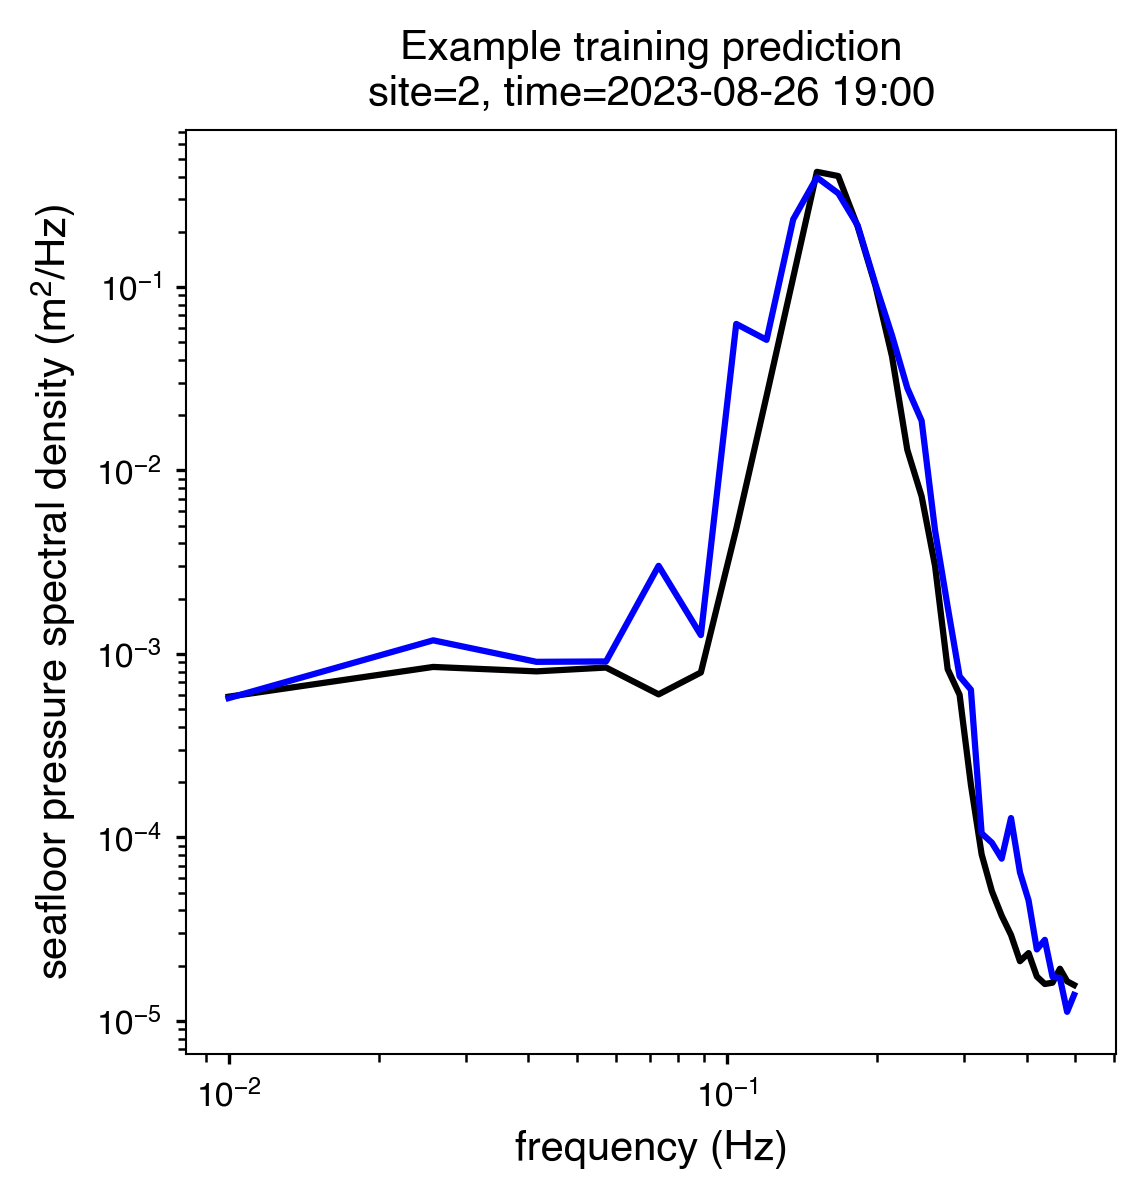

In [19]:
site = np.random.choice(das_30min_ds['site'].size)
time = np.random.choice(das_30min_ds['time'].size)

if das_30min_ds.isel(site=site, time=time)['is_train']:
    title_label = 'training'
    prediction_color = 'b'
else:
    title_label = 'test'
    prediction_color = 'r'

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.loglog(
    das_30min_ds['frequency'],
    das_30min_ds.isel(site=site, time=time)['target_seafloor_pressure_spectral_density'],
    color='k',
    label='target',
)
ax.loglog(
    das_30min_ds['frequency'],
    das_30min_ds.isel(site=site, time=time)['seafloor_pressure_spectral_density'],
    color=prediction_color,
    label='prediction',
)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('seafloor pressure spectral density (m$^2$/Hz)')
ax.set_title(
    f'Example {title_label} prediction\n'
    f'site={das_30min_ds.site[site].item()}, '
    f'time={das_30min_ds.time[time].dt.strftime("%Y-%m-%d %H:%M").item()}'
)

Transform seafloor pressure spectral densities to surface elevation spectral densities and compute bulk variables.

In [20]:
# Attenuation cutoff is set to remove erroneous tail shape.
ATTENUATION_CUTOFF = 25

das_30min_ds['seafloor_pressure_variance'] = waves.spectral_var(
    das_30min_ds['seafloor_pressure_spectral_density']
)

das_30min_ds['energy_period'] = waves.energy_period(
    das_30min_ds['seafloor_pressure_spectral_density'],
)

attenuation_tf = waves.pressure_spectra_to_surface_spectra(
    depth=das_30min_ds['depth'],
    frequency=das_30min_ds['frequency'],
)

das_30min_ds['pressure_to_surface_transfer_function'] = attenuation_tf.where(
    attenuation_tf < ATTENUATION_CUTOFF,
    np.nan
)

das_30min_ds['surface_elevation_spectral_density'] = \
    das_30min_ds['seafloor_pressure_spectral_density'] * das_30min_ds['pressure_to_surface_transfer_function']

das_30min_ds['significant_wave_height'] = waves.significant_wave_height(
    das_30min_ds['surface_elevation_spectral_density'].fillna(0)  # Could handle NaNs better here.
)


Reindex the dataset by site.

In [21]:
das_30min_ds = das_xarray_helpers.index_by_site(das_30min_ds)

Separate training and test datasets for plotting.

In [22]:
das_30min_train_ds = das_xarray_helpers.get_train(das_30min_ds)
das_30min_test_ds = das_xarray_helpers.get_test(das_30min_ds)

Plot the training, test, and target significant wave heights over the entire analysis period.

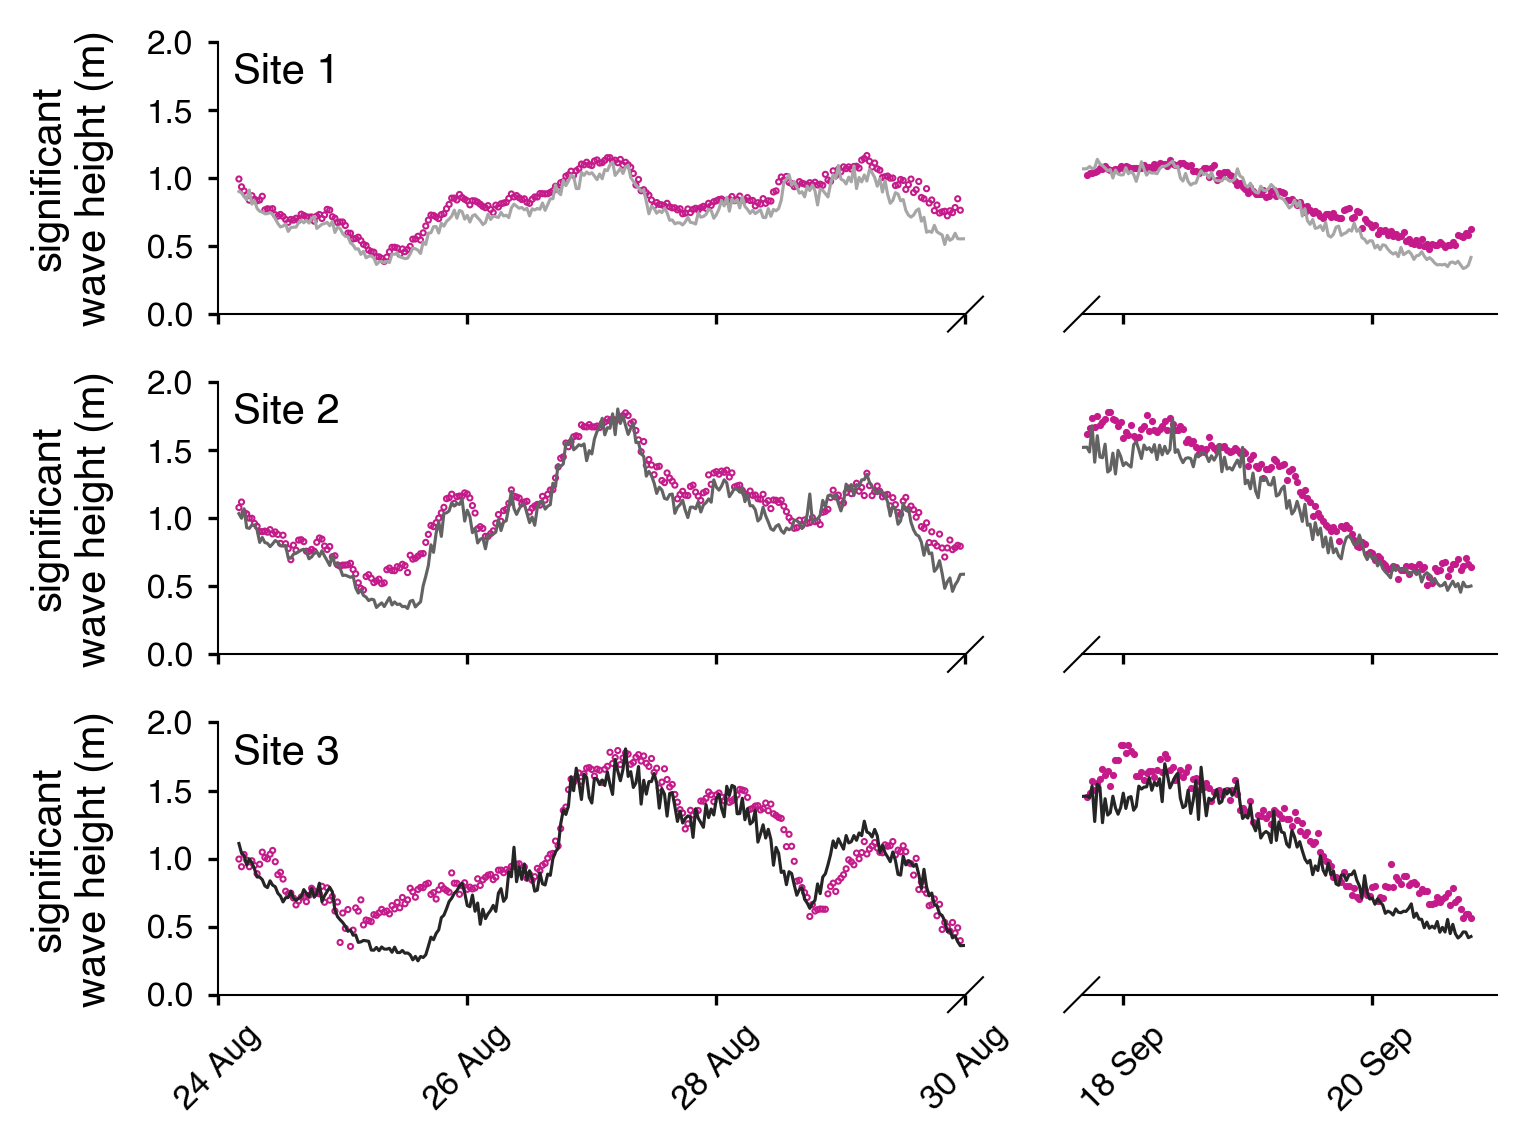

In [23]:
sites = [1, 2, 3]
start_time = pd.Timestamp('2023-08-24')
end_time = pd.Timestamp('2023-09-21')

# Create a three-panel time series using the brokenaxes package.
fig = plt.figure(figsize=(plots.figure_full_width, plots.figure_full_width*3/4))
gridspec = GridSpec(3, 1, hspace=0.25, wspace=0.1)
ax_1 = plots.create_time_series_axes(start_time, end_time, gridspec[0])
ax_2 = plots.create_time_series_axes(start_time, end_time, gridspec[1])
ax_3 = plots.create_time_series_axes(start_time, end_time, gridspec[2])
axes = [ax_1, ax_2, ax_3]

for ax, site in zip(axes, sites):
    ax.scatter(
        das_30min_train_ds.sel(site=site)['time'],
        das_30min_train_ds.sel(site=site)['significant_wave_height'],
        label=f'Site {site}',
        color=plots.spectral_nn_color,
        **plots.train_scatter_kwargs,
    )
    ax.scatter(
        das_30min_test_ds.sel(site=site)['time'],
        das_30min_test_ds.sel(site=site)['significant_wave_height'],
        label=f'Site {site}',
        color=plots.spectral_nn_color,
        **plots.test_scatter_kwargs,
    )
    ax.plot(
        das_30min_ds.sel(site=site)['time'],
        das_30min_ds.sel(site=site)['target_significant_wave_height'],
        label=f'Site {site}',
        color=plots.mooring_site_colors[site],
        **plots.mooring_plot_kwargs,
    )
    ax.axs[0].annotate(f'Site {site}', xy=(0.02, 0.85), xycoords='axes fraction')
    ax.set_ylim([0, 2])
    ax.set_ylabel('significant\nwave height (m)', labelpad=25)
    plots.configure_time_series_xaxis(
        start_time, end_time, ax,
        labels=True if ax==axes[-1] else False
    )
